In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import pathlib

from torch.utils.data import DataLoader

from utils.mri_data import SliceDataset
from utils.data_transform import DataTransform_Diffusion
from utils.sample_mask import RandomMaskGaussianDiffusion, RandomMaskDiffusion, RandomMaskDiffusion2D
from utils.misc import *
from help_func import print_var_detail

from diffusion.kspace_diffusion import KspaceDiffusion
from utils.diffusion_train import Trainer
from net.u_net_diffusion import Unet

import fastmri

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

2.5.1+cu124
device: cuda


In [2]:
# # ****** TRAINING SETTINGS ******
# # dataset settings
# acc = 8  # acceleration factor
# frac_c = 0.04  # center fraction
# path_dir_train = '/home/alvin/UltrAi/Datasets/raw_datasets/fastmri/knee_singlecoil/singlecoil_train/'
# path_dir_test = '/home/alvin/UltrAi/Datasets/raw_datasets/fastmri/knee_singlecoil/singlecoil_test/'
# img_mode = 'fastmri'  # 'fastmri' or 'B1000'
# bhsz = 2
# img_size = 320

In [3]:
def get_data_loader(acc, frac_c, path_dir_test, img_size, batch_size=1, shuffle=False):
    # ====== Construct dataset ======
    # initialize mask
    mask_func = RandomMaskDiffusion(
        acceleration=acc,
        center_fraction=frac_c,
        size=(1, img_size, img_size),
    )

    # initialize dataset
    data_transform = DataTransform_Diffusion(
        mask_func,
        img_size=img_size,
        combine_coil=True,
        flag_singlecoil=False,
    )

    dataset = SliceDataset(
        root=pathlib.Path(path_dir_test),
        transform=data_transform,
        challenge='multicoil',
        num_skip_slice=5,
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True,
    )

/tmp/ipykernel_332808/3880673156.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  magnitude = torch.Tensor(np.log(np.sqrt(kspace[...,0]**2 + kspace[...,1]**2) + 1e-9))
/tmp/ipykernel_332808/3880673156.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  magnitude_us = torch.Tensor(np.log(np.sqrt(kspace_us[...,0]**2 + kspace_us[...,1]**2) + 1e-9))


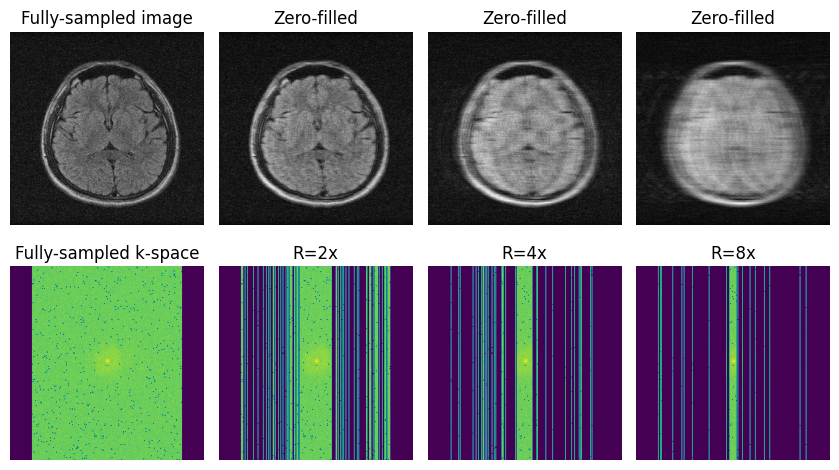

In [29]:
# ****** TRAINING SETTINGS ******
# dataset settings
acc = 2  # acceleration factor
frac_c = 0.16  # center fraction
path_dir_train = '/home/alvin/UltrAi/Datasets/raw_datasets/m4raw/multicoil_train'
path_dir_test = '/home/alvin/UltrAi/Datasets/raw_datasets/m4raw/multicoil_val'
img_mode = 'fastmri'  # 'fastmri' or 'B1000'
bhsz = 8
img_size = 256

id = np.random.randint(0, bhsz)

plt.figure(figsize=(8.5, 5))
rows, cols = 2, 4
n = 0

for i, (acc, frac_c) in enumerate([(1., 0.32), (2, 0.16), (4, 0.08), (8, 0.04)]):
    dataloader_train = get_data_loader(acc, frac_c, path_dir_train, img_size, batch_size=bhsz)

    kspace, mask, mask_fold = next(iter(dataloader_train))
    # undersample the kspace
    kspace_us = kspace * mask.unsqueeze(-1)
    
    magnitude = torch.Tensor(np.log(np.sqrt(kspace[...,0]**2 + kspace[...,1]**2) + 1e-9))
    magnitude_us = torch.Tensor(np.log(np.sqrt(kspace_us[...,0]**2 + kspace_us[...,1]**2) + 1e-9))

    # get image ifft
    image = fastmri.ifft2c(kspace)
    image = fastmri.complex_abs(image)
    # combine coils with rss
    image = fastmri.rss(image, dim=1)

    # get undersampled image
    image_us = fastmri.ifft2c(kspace_us)
    image_us = fastmri.complex_abs(image_us)
    # combine coils with rss
    image_us = fastmri.rss(image_us, dim=1)

    if acc == 1:
        plt.subplot(rows, cols, n+cols+1)
        plt.imshow(magnitude[id, 0])
        plt.title('Fully-sampled k-space')
        plt.axis('off')
        plt.subplot(rows, cols, n+1)
        plt.imshow(image[id], cmap='gray')
        plt.title('Fully-sampled image')
        plt.axis('off')
    else:
        plt.subplot(rows, cols, n+cols+1)
        plt.imshow(magnitude_us[id, 0])
        plt.title(f'R={acc}x')
        plt.axis('off')
        plt.subplot(rows, cols, n+1)
        plt.imshow(image_us[id], cmap='gray')
        plt.title('Zero-filled')
        plt.axis('off')

    n += 1

plt.tight_layout()
save_dir = "/home/alvin/Masters/EECE_571/final_report/figures"
plt.savefig(f'{save_dir}/undersampling.svg', format='svg', dpi=500, bbox_inches='tight')
plt.show()


In [ ]:
# ****** TRAINING SETTINGS ******
# dataset settings
acc = 2  # acceleration factor
frac_c = 0.16  # center fraction
path_dir_train = '/home/alvin/UltrAi/Datasets/raw_datasets/m4raw/multicoil_train'
path_dir_test = '/home/alvin/UltrAi/Datasets/raw_datasets/m4raw/multicoil_val'
img_mode = 'fastmri'  # 'fastmri' or 'B1000'
bhsz = 8
img_size = 256

id = np.random.randint(0, bhsz)

plt.figure(figsize=(12, 7))
rows, cols = 2, 4
n = 0
for i, (acc, frac_c) in enumerate([(2, 0.16), (4, 0.08), (8, 0.04), (16, 0.02)]):
    dataloader_train = get_data_loader(acc, frac_c, path_dir_train, img_size, batch_size=bhsz)

    kspace, mask, mask_fold = next(iter(dataloader_train))
    # undersample the kspace
    kspace_us = kspace * mask.unsqueeze(-1)
    
    magnitude = torch.Tensor(np.log(np.sqrt(kspace[...,0]**2 + kspace[...,1]**2) + 1e-9))
    magnitude_us = torch.Tensor(np.log(np.sqrt(kspace_us[...,0]**2 + kspace_us[...,1]**2) + 1e-9))

    # get image ifft
    image = fastmri.ifft2c(kspace)
    image = fastmri.complex_abs(image)
    # combine coils with rss
    # image = fastmri.rss(image, dim=1)

    # # get undersampled image
    # image_us = fastmri.ifft2c(kspace_us)
    # image_us = fastmri.complex_abs(image_us)
    # # combine coils with rss
    # image_us = fastmri.rss(image_us, dim=1)

    # # if n == 0:
    # #     plt.subplot(rows, cols, cols*n+1)
    # #     plt.imshow(magnitude[id, 0])
    # #     plt.axis('off')
    # # else:
    # plt.subplot(rows, cols, 1 + n)
    # plt.imshow(magnitude_us[id, 0])
    # # plt.title('Fully-sampled k-space')
    # plt.axis('off')
    
    # plt.subplot(rows, cols, 5 + n)
    # plt.imshow(mask[id].squeeze(), cmap='gray')
    # plt.axis('off')

#     n += 1

# plt.tight_layout()
# # save figure as svg
# plt.savefig('/home/alvin/Masters/EECE_571/final_report/mask_comparison.svg', format='svg')
# plt.show()


/tmp/ipykernel_31457/3796311698.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  magnitude = torch.Tensor(np.log(np.sqrt(kspace[...,0]**2 + kspace[...,1]**2) + 1e-9))
/tmp/ipykernel_31457/3796311698.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  magnitude_us = torch.Tensor(np.log(np.sqrt(kspace_us[...,0]**2 + kspace_us[...,1]**2) + 1e-9))


<Figure size 1200x700 with 0 Axes>

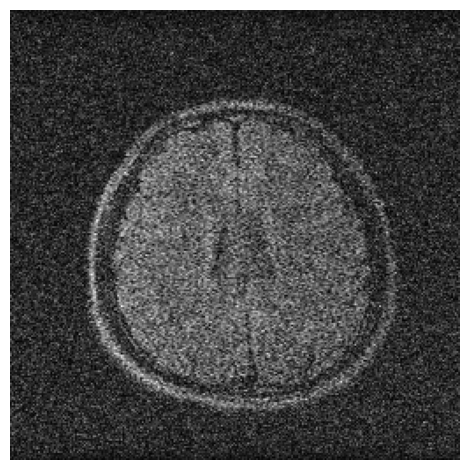

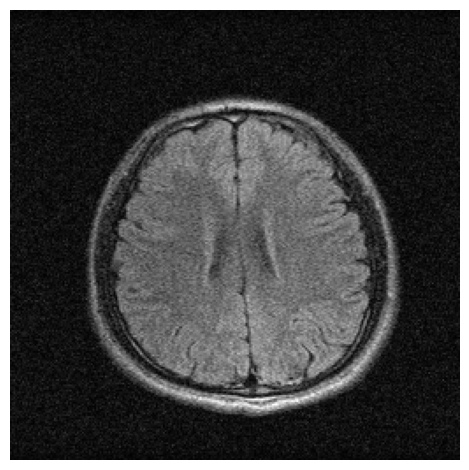

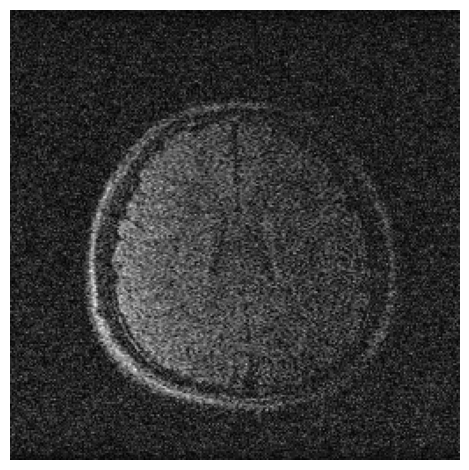

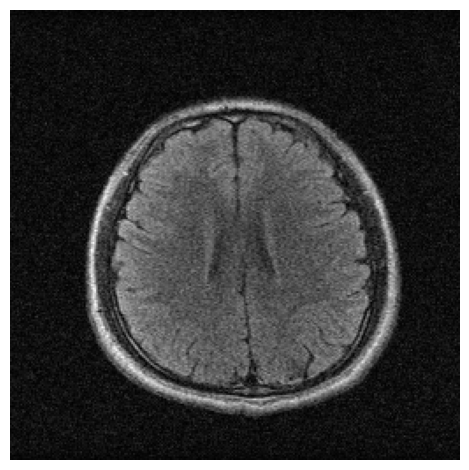

In [ ]:
for c in range(4):
    # rescalse image
    plt.imshow(image[id, c], cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    # remove white space
    plt.savefig(f'/home/alvin/Masters/EECE_571/final_report/original_image{c}.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()